## Create a Decision Tree that can predict the survival of passengers on the Titanic
Make sure not to impose any restrictions on the depth of the tree

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# for visualisation
import matplotlib.pyplot as plt


%matplotlib inline

__Data dictionary:__ 
- PassengerId: Unique ID of a passenger
- Pclass: ticket class, 1 = 1st/upper, 2 = 2nd/middle, 3 = 3rd/lower
- Age: age in years
- SibSp: # of siblings/spouses aboard the Titanic
- Parch: # of parents/children aboard the Titanic
- Ticket: ticket number
- Fare: Passenger fare
- Cabin: cabin number
- Embarked: Port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

### Load datset

In [2]:
# importing the dataset
data = pd.read_csv('titanic.csv')
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
# quick check at data types & null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


_From the above, the dataset is a combination of numeric data and categorical data_ 
1. The 'Embarked' feature has only 2 missing values, these records can be dropped
2. The 'Age' feature has 891-714 = 177 missing values, this can be filled with its mean value
3. The 'Cabin' feature has 891-204 = 687 missing values, which looks like a lot. For this exploratory practise, this series is dropped.
4. The 'passengerId','Name' and 'Ticket' are not needed for the analysis and will be dropped as well.

In [4]:
# drop null data for 'Embarked'
data = data.dropna(subset = ['Embarked'])

# fill 'Age' null values with the mean
data['Age'].fillna(data['Age'].mean(), inplace = True)

# drop 'Cabin' and 'PassengerID' columns
data = data.drop('PassengerId', axis = 1)
data = data.drop('Cabin', axis = 1)
data = data.drop('Name', axis = 1)
data = data.drop('Ticket', axis = 1)


data.info(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


_all the missing values have been processed._

In [5]:
# data preparation, categrical values into interger values, ETC

# For 'Sex' column, set 'male' = 0, 'female' = 1
sex_nums ={'Sex': {'male': 0, 'female': 1}}
data = data.replace(sex_nums)
data['Sex'].value_counts()
# For 'Embarked' column, set 'C'(Cherbourg) = 0, 'Q'(Queenstown) = 1, 'S'(Southampton)= 2
embarked_nums ={'Embarked': {'C': 0, 'Q': 1, 'S': 2}}
data = data.replace(embarked_nums)

# Mapping Fare
data.loc[data['Fare'] <= 7.9, 'Fare'] = 0
data.loc[(data['Fare'] > 7.9) & (data['Fare'] <= 14.5), 'Fare'] = 1
data.loc[(data['Fare'] > 14.5) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[ data['Fare'] > 31, 'Fare'] = 3
data['Fare'] = data['Fare'].astype(int)

# Mapping Age
data.loc[data['Age'] <= 16, 'Age'] = 0
data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age']   = 2
data.loc[ data['Age'] > 48, 'Age'] = 3
data['Age'] = data['Age'].astype(int)


data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,1,1,0,0,2
1,1,1,1,2,1,0,3,0
2,1,3,1,1,0,0,1,2
3,1,1,1,2,1,0,3,2
4,0,3,0,2,0,0,1,2


### Select relevant variables from the data and split the data into a training, development and test set

<AxesSubplot: >

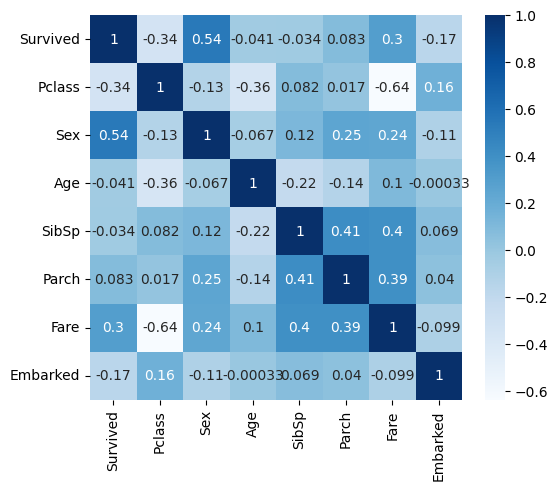

In [6]:
plt.figure(figsize=(6,5))
sns.heatmap(data.corr(), annot=True, cmap='Blues')

_From the heatmap, 'Sex' shows the highest correlations with 'Survived'._

In [7]:
# split the data
x = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
r=4
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=r)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.2, random_state=r)
print ("Training data:",x_train.shape, y_train.shape)
print ("Development data:",x_dev.shape, y_dev.shape)
print ("Test data:",x_test.shape, y_test.shape)

Training data: (568, 7) (568,)
Development data: (143, 7) (143,)
Test data: (178, 7) (178,)


### Train decision trees
create a Bagged, Random Forest, and Boosted tree for the titanic dataset same way as as a regular Classification Tree

In [8]:
# Regular classification tree_training a model without pruning
regular = DecisionTreeClassifier(max_depth=None, random_state=r)
regular.fit(x_train, y_train)


DecisionTreeClassifier(random_state=4)

In [9]:
# Bagged tree_training a model without pruning
base_cls = DecisionTreeClassifier()
bagged = BaggingClassifier(base_estimator=base_cls, n_estimators = 10, random_state=r)
base_cls.fit(x_train, y_train)
bagged.fit(x_train, y_train)

c:\Users\Feifei\.conda\envs\Fei-Env-Python10\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=4)

In [10]:
# Random forest_training a model without pruning
forest = RandomForestClassifier(n_estimators=10, random_state=r)
forest.fit(x_train, y_train)

# view importance scores for features in the dataset
feature_imp = pd.Series(forest.feature_importances_).sort_values(ascending=False)
feature_imp


1    0.314238
5    0.162158
0    0.151438
2    0.111466
3    0.089669
4    0.088794
6    0.082237
dtype: float64

In [13]:
# boosted tree_training a model without pruning
boost = AdaBoostClassifier(n_estimators=10, random_state=r)
boost.fit(x_train, y_train)

AdaBoostClassifier(n_estimators=10, random_state=4)

### Pick one of these methods, and tune the parameters n_estimators and max_depth. 

RandomForestClassifier is selected as an example

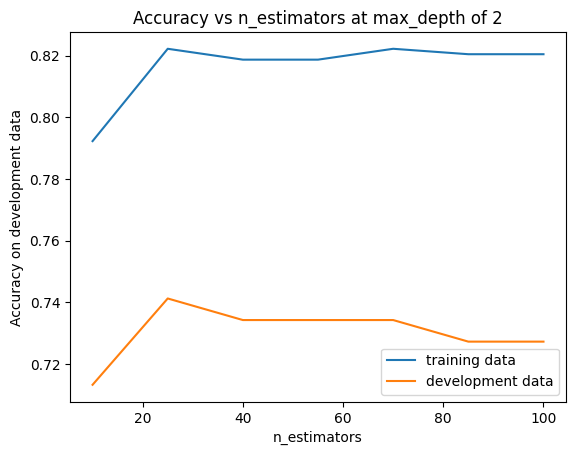

tra_score [0.7922535211267606, 0.8221830985915493, 0.8186619718309859, 0.8186619718309859, 0.8221830985915493, 0.8204225352112676, 0.8204225352112676]
dev_score [0.7132867132867133, 0.7412587412587412, 0.7342657342657343, 0.7342657342657343, 0.7342657342657343, 0.7272727272727273, 0.7272727272727273]


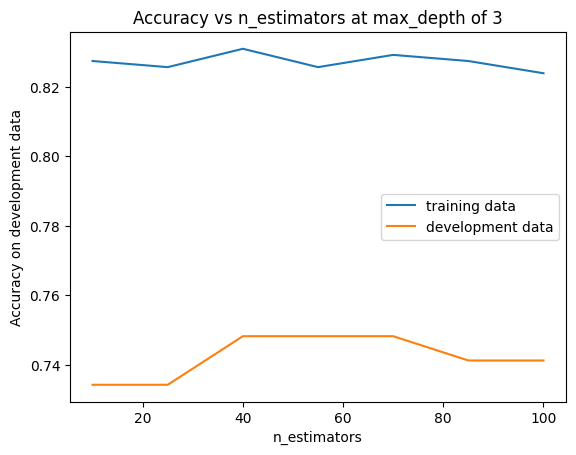

tra_score [0.8274647887323944, 0.8257042253521126, 0.8309859154929577, 0.8257042253521126, 0.829225352112676, 0.8274647887323944, 0.823943661971831]
dev_score [0.7342657342657343, 0.7342657342657343, 0.7482517482517482, 0.7482517482517482, 0.7482517482517482, 0.7412587412587412, 0.7412587412587412]


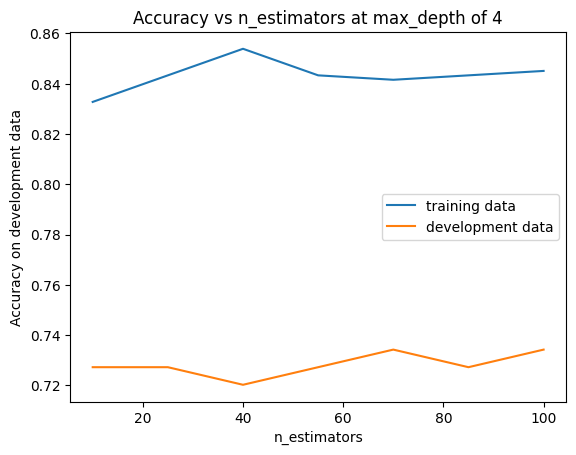

tra_score [0.8327464788732394, 0.8433098591549296, 0.8538732394366197, 0.8433098591549296, 0.8415492957746479, 0.8433098591549296, 0.8450704225352113]
dev_score [0.7272727272727273, 0.7272727272727273, 0.7202797202797203, 0.7272727272727273, 0.7342657342657343, 0.7272727272727273, 0.7342657342657343]


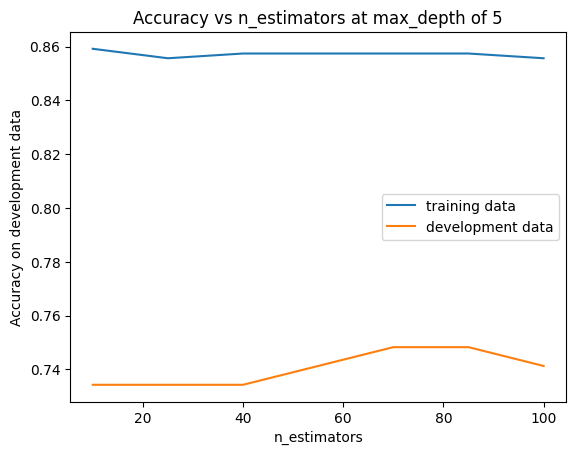

tra_score [0.8591549295774648, 0.8556338028169014, 0.8573943661971831, 0.8573943661971831, 0.8573943661971831, 0.8573943661971831, 0.8556338028169014]
dev_score [0.7342657342657343, 0.7342657342657343, 0.7342657342657343, 0.7412587412587412, 0.7482517482517482, 0.7482517482517482, 0.7412587412587412]


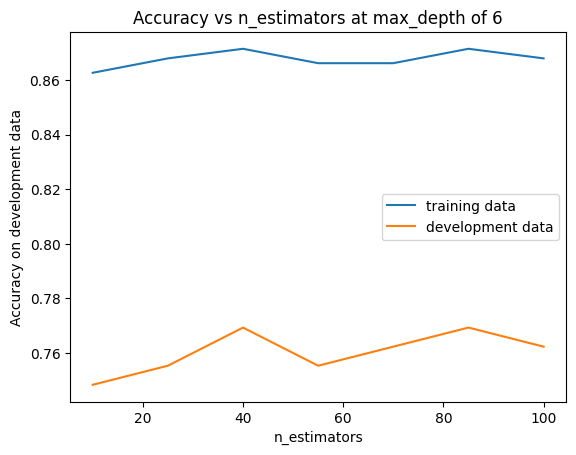

tra_score [0.8626760563380281, 0.8679577464788732, 0.8714788732394366, 0.8661971830985915, 0.8661971830985915, 0.8714788732394366, 0.8679577464788732]
dev_score [0.7482517482517482, 0.7552447552447552, 0.7692307692307693, 0.7552447552447552, 0.7622377622377622, 0.7692307692307693, 0.7622377622377622]


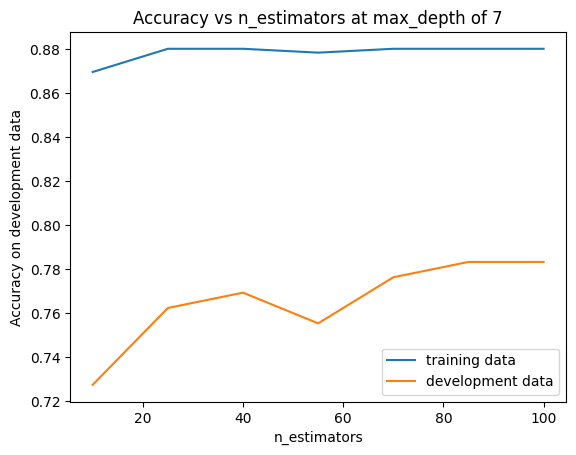

tra_score [0.8697183098591549, 0.8802816901408451, 0.8802816901408451, 0.8785211267605634, 0.8802816901408451, 0.8802816901408451, 0.8802816901408451]
dev_score [0.7272727272727273, 0.7622377622377622, 0.7692307692307693, 0.7552447552447552, 0.7762237762237763, 0.7832167832167832, 0.7832167832167832]


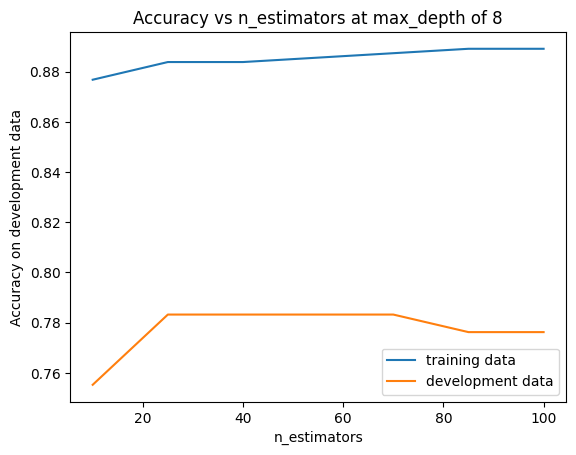

tra_score [0.8767605633802817, 0.8838028169014085, 0.8838028169014085, 0.8855633802816901, 0.8873239436619719, 0.8890845070422535, 0.8890845070422535]
dev_score [0.7552447552447552, 0.7832167832167832, 0.7832167832167832, 0.7832167832167832, 0.7832167832167832, 0.7762237762237763, 0.7762237762237763]


In [14]:
# Use random forest model
forest_depths = range(2, 9)
forest_estimators = [10, 25, 40, 55, 70, 85, 100]


for h in forest_depths:
    train_scores = []
    dev_scores = []
    for e in forest_estimators:
        clf = RandomForestClassifier(max_depth=h, n_estimators=e, random_state=r)
        clf.fit(x_train, y_train)
        train_score = clf.score(x_train, y_train)
        train_scores.append(train_score)
        dev_score = clf.score(x_dev, y_dev)
        dev_scores.append(dev_score)


    # plot graph for accuracy with various n_estimators at max_depth value
    fig, ax = plt.subplots()
    ax.plot(forest_estimators, train_scores, label='training data')
    ax.plot(forest_estimators, dev_scores, label='development data')

    plt.title(f'Accuracy vs n_estimators at max_depth of {h}')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy on development data')
    plt.legend()
    plt.show()
    print('tra_score', train_scores)
    print('dev_score', dev_scores)



_From above results, the best fitting results for random forest is obtained when max_depth is 8 and when n_estimators is 75. The turned accuracy on development data is 0.7832167832167832._

### Report the accuracy of all models and report which model performed the best
including the values for n_estimators and max_depth that the best model had

In [18]:
print('Accuracy for regular decision tree:', regular.score(x_test, y_test))
print('Accuracy for bagged tree:', bagged.score(x_test, y_test))
print('Accuracy for random forest:', forest.score(x_test, y_test))
print('Accuracy for boosted tree:', boost.score(x_test, y_test))

clf = RandomForestClassifier(max_depth=8, n_estimators=75, random_state=r)
clf.fit(x_train, y_train)

print(f'''For optimised random forest: 
 - max_depth is 8,
 - n_estimator is 75,
 - accuracy is {clf.score(x_test, y_test)}''')



Accuracy for regular decision tree: 0.8033707865168539
Accuracy for bagged tree: 0.7808988764044944
Accuracy for random forest: 0.7752808988764045
Accuracy for boosted tree: 0.7865168539325843
For optimised random forest: 
 - max_depth is 8,
 - n_estimator is 75,
 - accuracy is 0.8089887640449438
